In [1]:
import sys
!conda install --yes --prefix {sys.prefix} pandasql

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pandasql


The following NEW packages will be INSTALLED:

  pandasql           conda-forge/noarch::pandasql-0.7.3-pyhd8ed1ab_0

The following packages will be UPDATED:

  ca-certificates                      2021.5.30-ha878542_0 --> 2021.10.8-ha878542_0
  certifi                          2021.5.30-py39hf3d152e_0 --> 2021.10.8-py39hf3d152e_1
  openssl                                 1.1.1k-h7f98852_1 --> 1.1.1l-h7f98852_0


Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [2]:
import pandas as p
from pandasql import sqldf
from sklearn.model_selection import train_test_split
pysqldf = lambda q: sqldf(q, globals())

In [34]:
df_people = p.read_csv('../data/People.csv')
df_salaries = p.read_csv('../data/Salaries.csv')
df_appearances = p.read_csv('../data/Appearances.csv')
df_batting = p.read_csv('../data/Batting.csv')
df_fielding = p.read_csv('../data/Fielding.csv')

In [160]:
def display_stats(df, columnLabel, inc = 1, rnd = 0):
    numObj, minValue, maxValue, mean, stdev, Q1, median, Q3, IQR = [0,"inf","-inf",0,0,0,0,0,0]
    
    numObj = len(df)
    minValue = df[columnLabel].min()
    maxValue = df[columnLabel].max()
    mean = df[columnLabel].mean()
    stdev = df[columnLabel].std()
    Q1 = df[columnLabel].quantile(.25)
    median = df[columnLabel].median()
    Q3 = df[columnLabel].quantile(.75)
    IQR = Q3 - Q1
    
    print(f"""
      Min Value: {minValue}
      Max Value: {maxValue}
      Mean: {mean}
      Median: {median}
      Standard Deviation: {stdev}
      Q1: {Q1}
      Q3: {Q3}
      IQR: {IQR}
      ---
      Poorest: {minValue} - {max(0, Q1 - (1.5 * IQR))}
      Poor: {max(0, Q1 - (1.5 * IQR) + inc)} - {Q1}
      Fair: {Q1 + inc} - {median}
      Good: {median + inc} - {Q3}
      Great: {Q3 + inc} - {min(maxValue, Q3 + (1.5 * IQR))}
      Excellent: {min(maxValue, Q3 + (1.5 * IQR))} - {maxValue}
    """)

    return numObj, minValue, maxValue, mean, stdev, Q1, median, Q3, IQR

In [173]:
df_playerids = pysqldf("SELECT DISTINCT playerID from df_people group by playerID")
df_playerids.head(5)

batting_stats = pysqldf("""
    SELECT playerID, yearID, G, H / (AB - BB - SF) as BattingAverage, AB, R, H, HR, RBI, BB, SF 
    FROM df_batting 
    WHERE G >= 50 and AB > 0 and yearID > 1955
""")

player_salaries = pysqldf("""
    SELECT stats.playerID, stats.yearID, df_salaries.salary,
        next.salary as 'NextSalary',
        (next.salary - df_salaries.salary * 1.0) / ABS(df_salaries.salary) as Difference,
        G, BattingAverage, AB, R, H, HR, RBI, BB, SF
    FROM batting_stats as stats
    INNER JOIN df_salaries ON df_salaries.playerID = stats.playerID AND df_salaries.yearID = stats.yearID
    INNER JOIN (
        SELECT salary, playerID, yearID
        FROM df_salaries as next
    ) next ON df_salaries.playerID = next.playerID AND (df_salaries.yearID + 1) = next.yearID
""")

# player_salaries[ player_salaries['playerID'] == 'aguaylu01'].head(5)

fielders = pysqldf("""
    SELECT DISTINCT ps.playerID, ps.yearID, salary, NextSalary, Difference, POS, ps.G, BattingAverage, AB, R, H, HR, RBI, BB, SF, (PO + A) / (PO + A + E) as FieldingPercentage, A, E, PO
    FROM player_salaries AS ps
    INNER JOIN df_fielding ON ps.playerID=df_fielding.playerID AND ps.yearID=df_fielding.yearID
""")

# # fielders.head(5)

updated = fielders.groupby(['playerID', 'yearID']).agg({
    'G': ['first'],
    'AB': ['first'],
    'H': ['first'],
    'HR': ['first'],
    'RBI': ['first'],
    'BB': ['first'],
    'SF': ['first'],
    'A': ['sum'],
    'E': ['sum'],
    'PO': ['sum'],
    'salary': ['first'],
    'NextSalary': ['first'],
    'Difference': ['first'],
})
updated['FieldingPercentage'] = (updated['A'] + updated['PO']) / (updated['PO'] + updated['A'] + updated['E'])
updated['BattingAverage'] = updated['H'] / (updated['AB'] - updated['BB'] - updated['SF'])
updated.columns = updated.columns.droplevel(1)

# final_frame = updated[ updated['AB'] >= 500 ]

# fp_ax = updated[ updated['G'] >= 100].plot.scatter(x="FieldingPercentage", y="salary")
# fp_ax.set_xlim(0.8, 1)

# updated[ updated['AB'] >= 500 ].plot.scatter(x="HR", y="salary")
# ba_ax = updated[ updated['AB'] >= 500 ].plot.scatter(x="BattingAverage", y="salary")
# ba_ax.set_xlim(0, 0.5)ON df_salaries.playerID = next.playerID AND (df_salaries.yearID + 1) = next.yearID`


      Min Value: 0
      Max Value: 73
      Mean: 11.024590163934427
      Median: 8.0
      Standard Deviation: 10.37919716751357
      Q1: 3.0
      Q3: 16.25
      IQR: 13.25
      ---
      Poorest: 0 - 0
      Poor: 0 - 3.0
      Fair: 4.0 - 8.0
      Good: 9.0 - 16.25
      Great: 17.25 - 36.125
      Excellent: 36.125 - 73
    


G   AB    H  HR   RBI  BB   SF    A     E   PO  salary  \
playerID  yearID                                                             
abbotje01 1998     89  244   68  12  41.0   9  5.0    0   4.0  132  175000   
          2000     80  215   59   3  29.0  21  1.0    2   2.0  101  255000   
abbotku01 1994    101  345   86   9  33.0  16  2.0  260  15.0  162  109000   
          1995    120  420  107  17  60.0  36  5.0  290  19.0  149  119000   
          1996    109  320   81   8  33.0  22  0.0  205  12.0  123  250000   

                  NextSalary  Difference  FieldingPercentage  BattingAverage  \
playerID  yearID                                                               
abbotje01 1998        255000    0.457143            0.970588        0.295652   
          2000        300000    0.176471            0.980952        0.305699   
abbotku01 1994        119000    0.091743            0.965675        0.262997   
          1995        250000    1.100840            0.958515        0.282322   
          1996        650000    1.600000            0.964706        0.271812   

                 Salary_Increase HR_Cat  
playerID  yearID                         
abbotje01 1998              Good   Good  
          2000              Fair   Poor  
abbotku01 1994              Fair   Fair  
          1995         Excellent   Good  
          1996         Excellent   Fair

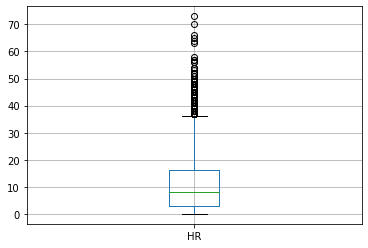

In [175]:
updated['HR_Cat'] = p.cut(updated['HR'], bins=[0, 1, 3, 9, 17, 36, 100], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"])
display_stats(updated, 'HR')
hr_axes = updated.boxplot(column=['HR'], return_type='axes')

updated.head(5)



      Min Value: 0.0
      Max Value: 165.0
      Mean: 47.14439573008006
      Median: 43.0
      Standard Deviation: 31.91255005872307
      Q1: 23.0
      Q3: 68.0
      IQR: 45.0
      ---
      Poorest: 0.0 - 0
      Poor: 0 - 23.0
      Fair: 24.0 - 43.0
      Good: 44.0 - 68.0
      Great: 69.0 - 135.5
      Excellent: 135.5 - 165.0
    


G   AB    H  HR   RBI  BB   SF    A     E   PO  salary  \
playerID  yearID                                                             
abbotje01 1998     89  244   68  12  41.0   9  5.0    0   4.0  132  175000   
          2000     80  215   59   3  29.0  21  1.0    2   2.0  101  255000   
abbotku01 1994    101  345   86   9  33.0  16  2.0  260  15.0  162  109000   
          1995    120  420  107  17  60.0  36  5.0  290  19.0  149  119000   
          1996    109  320   81   8  33.0  22  0.0  205  12.0  123  250000   

                  NextSalary  Difference  FieldingPercentage  BattingAverage  \
playerID  yearID                                                               
abbotje01 1998        255000    0.457143            0.970588        0.295652   
          2000        300000    0.176471            0.980952        0.305699   
abbotku01 1994        119000    0.091743            0.965675        0.262997   
          1995        250000    1.100840            0.958515        0.282322   
          1996        650000    1.600000            0.964706        0.271812   

                 Salary_Increase HR_Cat RBI_Cat  
playerID  yearID                                 
abbotje01 1998              Good   Good    Fair  
          2000              Fair   Poor    Fair  
abbotku01 1994              Fair   Fair    Fair  
          1995         Excellent   Good    Good  
          1996         Excellent   Fair    Fair

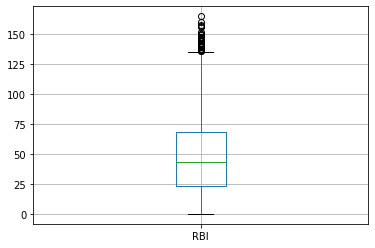

In [176]:
updated['RBI_Cat'] = p.cut(updated['RBI'], bins=[0, 1, 24, 44, 69, 135, 200], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"])
display_stats(updated, 'RBI')
updated.boxplot(column=['RBI'], return_type='axes')

updated.head(5)


      Min Value: 0.0
      Max Value: inf
      Mean: inf
      Median: 0.2949438202247191
      Standard Deviation: nan
      Q1: 0.2647058823529412
      Q3: 0.3237885462555066
      IQR: 0.05908266390256545
      ---
      Poorest: 0.0 - 0.176081886499093
      Poor: 0.177081886499093 - 0.2647058823529412
      Fair: 0.2657058823529412 - 0.2949438202247191
      Good: 0.2959438202247191 - 0.3237885462555066
      Great: 0.3247885462555066 - 0.4124125421093548
      Excellent: 0.4124125421093548 - inf
    


G   AB    H  HR   RBI  BB   SF    A     E   PO  salary  \
playerID  yearID                                                             
abbotje01 1998     89  244   68  12  41.0   9  5.0    0   4.0  132  175000   
          2000     80  215   59   3  29.0  21  1.0    2   2.0  101  255000   
abbotku01 1994    101  345   86   9  33.0  16  2.0  260  15.0  162  109000   
          1995    120  420  107  17  60.0  36  5.0  290  19.0  149  119000   
          1996    109  320   81   8  33.0  22  0.0  205  12.0  123  250000   

                  NextSalary  Difference  FieldingPercentage  BattingAverage  \
playerID  yearID                                                               
abbotje01 1998        255000    0.457143            0.970588        0.295652   
          2000        300000    0.176471            0.980952        0.305699   
abbotku01 1994        119000    0.091743            0.965675        0.262997   
          1995        250000    1.100840            0.958515        0.282322   
          1996        650000    1.600000            0.964706        0.271812   

                 Salary_Increase HR_Cat RBI_Cat BA_Cat  
playerID  yearID                                        
abbotje01 1998              Good   Good    Fair   Fair  
          2000              Fair   Poor    Fair   Good  
abbotku01 1994              Fair   Fair    Fair   Poor  
          1995         Excellent   Good    Good   Fair  
          1996         Excellent   Fair    Fair   Fair

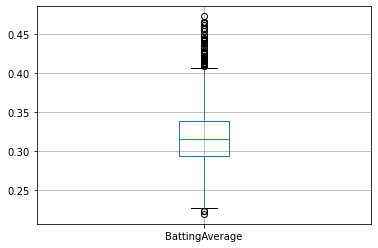

In [177]:
updated['BA_Cat'] = p.cut(updated['BattingAverage'], bins=[0.0, 0.177, 0.266, 0.296, 0.325, 0.412, 0.5], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"], precision=3)
display_stats(updated, 'BattingAverage', 0.001, 3)
ba_axes = updated[ updated['AB'] >= 500 ].boxplot(column=['BattingAverage'], return_type='axes')

updated.head(5)


      Min Value: 0.5
      Max Value: 1.0
      Mean: 0.9774664121043535
      Median: 0.9846153846153847
      Standard Deviation: 0.02838374498262916
      Q1: 0.9720465879862047
      Q3: 0.9924812030075187
      IQR: 0.02043461502131405
      ---
      Poorest: 0.5 - 0.9413946654542336
      Poor: 0.9423946654542336 - 0.9720465879862047
      Fair: 0.9730465879862047 - 0.9846153846153847
      Good: 0.9856153846153847 - 0.9924812030075187
      Great: 0.9934812030075187 - 1.0
      Excellent: 1.0 - 1.0
    


G   AB    H  HR   RBI  BB   SF    A     E   PO  salary  \
playerID  yearID                                                             
abbotje01 1998     89  244   68  12  41.0   9  5.0    0   4.0  132  175000   
          2000     80  215   59   3  29.0  21  1.0    2   2.0  101  255000   
abbotku01 1994    101  345   86   9  33.0  16  2.0  260  15.0  162  109000   
          1995    120  420  107  17  60.0  36  5.0  290  19.0  149  119000   
          1996    109  320   81   8  33.0  22  0.0  205  12.0  123  250000   

                  NextSalary  Difference  FieldingPercentage  BattingAverage  \
playerID  yearID                                                               
abbotje01 1998        255000    0.457143            0.970588        0.295652   
          2000        300000    0.176471            0.980952        0.305699   
abbotku01 1994        119000    0.091743            0.965675        0.262997   
          1995        250000    1.100840            0.958515        0.282322   
          1996        650000    1.600000            0.964706        0.271812   

                 Salary_Increase HR_Cat RBI_Cat BA_Cat FP_Cat  
playerID  yearID                                               
abbotje01 1998              Good   Good    Fair   Fair   Fair  
          2000              Fair   Poor    Fair   Good   Good  
abbotku01 1994              Fair   Fair    Fair   Poor   Fair  
          1995         Excellent   Good    Good   Fair   Fair  
          1996         Excellent   Fair    Fair   Fair   Fair

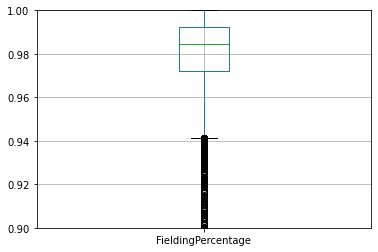

In [178]:
updated['FP_Cat'] = p.cut(updated['FieldingPercentage'], bins=[0, 0.5, 0.942, 0.973, 0.986, 0.993, 1], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"], precision=3)
display_stats(updated, 'FieldingPercentage', 0.001, 3)
fp_axes = updated[ updated['G'] >= 50 ].boxplot(column=['FieldingPercentage'], return_type='axes')
fp_axes.set_ylim(0.9, 1)

updated.head(5)


      Min Value: -1.0
      Max Value: 14.677966101694915
      Mean: 0.6019933643599863
      Median: 0.25
      Standard Deviation: 1.2507402487995114
      Q1: 0.03125
      Q3: 0.6923077056213027
      IQR: 0.6610577056213027
      ---
      Poorest: -1.0 - 0
      Poor: 0 - 0.03125
      Fair: 0.03225 - 0.25
      Good: 0.251 - 0.6923077056213027
      Great: 0.6933077056213027 - 1.6838942640532568
      Excellent: 1.6838942640532568 - 14.677966101694915
    


G   AB    H  HR   RBI  BB   SF    A     E   PO  salary  \
playerID  yearID                                                             
abbotje01 1998     89  244   68  12  41.0   9  5.0    0   4.0  132  175000   
          2000     80  215   59   3  29.0  21  1.0    2   2.0  101  255000   
abbotku01 1994    101  345   86   9  33.0  16  2.0  260  15.0  162  109000   
          1995    120  420  107  17  60.0  36  5.0  290  19.0  149  119000   
          1996    109  320   81   8  33.0  22  0.0  205  12.0  123  250000   

                  NextSalary  Difference  FieldingPercentage  BattingAverage  \
playerID  yearID                                                               
abbotje01 1998        255000    0.457143            0.970588        0.295652   
          2000        300000    0.176471            0.980952        0.305699   
abbotku01 1994        119000    0.091743            0.965675        0.262997   
          1995        250000    1.100840            0.958515        0.282322   
          1996        650000    1.600000            0.964706        0.271812   

                 Salary_Increase HR_Cat RBI_Cat BA_Cat FP_Cat  
playerID  yearID                                               
abbotje01 1998              Good   Good    Fair   Fair   Fair  
          2000              Fair   Poor    Fair   Good   Good  
abbotku01 1994              Fair   Fair    Fair   Poor   Fair  
          1995         Excellent   Good    Good   Fair   Fair  
          1996         Excellent   Fair    Fair   Fair   Fair

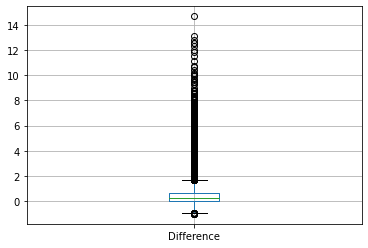

In [179]:
updated['Salary_Increase'] = p.cut(updated['Difference'], bins=[-1.0, 0, 0.032, 0.251, 0.693, 1, 15], labels=["Poorest", "Poor", "Fair", "Good", "Great", "Excellent"], precision=3)
display_stats(updated, 'Difference', 0.001)
diff_axes = updated[ updated['G'] >= 50 ].boxplot(column=['Difference'], return_type='axes')

updated.head(5)

In [191]:
# Reference: 
# https://deebuls.github.io/Naive-Bayes-Pandas.html
# 
def get_prior(df, attr):
    return df.groupby(attr).size().div(len(df))

probabilities = {}
# probabilities['Salary_Increase'] = get_prior(updated, 'Salary_Increase')
probabilities['HR'] = get_prior(updated, ['Salary_Increase', 'HR_Cat'])
probabilities['RBI'] = get_prior(updated, ['Salary_Increase', 'RBI_Cat'])
probabilities['Batting_Average'] = get_prior(updated, ['Salary_Increase', 'BA_Cat'])
probabilities['Fielding_Percentage'] = get_prior(updated, ['Salary_Increase', 'FP_Cat'])

print(probabilities)

{'HR': Salary_Increase  HR_Cat   
Poorest          Poorest      0.013725
                 Poor         0.026878
                 Fair         0.064430
                 Good         0.045082
                 Great        0.040698
                 Excellent    0.005147
Poor             Poorest      0.001811
                 Poor         0.003622
                 Fair         0.009531
                 Good         0.007815
                 Great        0.004670
                 Excellent    0.001048
Fair             Poorest      0.016203
                 Poor         0.028117
                 Fair         0.069100
                 Good         0.055566
                 Great        0.048894
                 Excellent    0.008006
Good             Poorest      0.012676
                 Poor         0.025067
                 Fair         0.063096
                 Good         0.052612
                 Great        0.046512
                 Excellent    0.005337
Great            Poorest      